In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

seed = 7

np.random.seed(seed)

period = '5min'
pair = 'BTC_ETH'
lag = 12

In [63]:
df = pd.read_csv('./datasets/{}/{}_train.csv'.format(period, pair), index_col=0)
df.head()

,open,high,low,close,volume
datetime,,,,,
1474205100,0.021000,0.021039,0.021000,0.021039,4.296642
1474205400,0.021042,0.021049,0.021038,0.021046,3.987229
1474205700,0.021042,0.021042,0.021000,0.021038,19.966953
1474206000,0.021025,0.021038,0.021000,0.021030,27.707384
1474206300,0.021001,0.021038,0.021001,0.021036,3.879610


In [64]:
df['close'].head()

datetime
1474205100    0.021039
1474205400    0.021046
1474205700    0.021038
1474206000    0.021030
1474206300    0.021036
Name: close, dtype: float64

In [65]:
df['close'].shift(1).head()

datetime
1474205100         NaN
1474205400    0.021039
1474205700    0.021046
1474206000    0.021038
1474206300    0.021030
Name: close, dtype: float64

In [66]:
(df['close'] - df['close'].shift(1)).head()

datetime
1474205100         NaN
1474205400    0.000008
1474205700   -0.000008
1474206000   -0.000008
1474206300    0.000006
Name: close, dtype: float64

In [67]:
close_lag_fields = []
for n in range(1, lag+1):
    k = 'close-' + str(n)
    df[k] = df['close'] - df.shift(n)['close']
    close_lag_fields.append(k)
df['up'] = df['close'] < df.shift(-1)['close']
df.dropna(inplace=True)
df.head()

,open,high,low,close,volume,close-1,close-2,close-3,close-4,close-5,close-6,close-7,close-8,close-9,close-10,close-11,close-12,up
datetime,,,,,,,,,,,,,,,,,,
1474208700,0.020975,0.021000,0.020975,0.020988,0.340518,1.254000e-05,-0.000032,-0.000034,-0.000042,-0.000012,-0.000007,-0.000012,-0.000048,-0.000043,-0.000050,-0.000058,-0.000051,False
1474209000,0.020981,0.021054,0.020975,0.020982,28.259740,-5.830000e-06,0.000007,-0.000038,-0.000040,-0.000048,-0.000018,-0.000012,-0.000018,-0.000054,-0.000049,-0.000056,-0.000064,True
1474209300,0.021020,0.021020,0.020982,0.020982,3.249647,3.200000e-07,-0.000006,0.000007,-0.000038,-0.000040,-0.000048,-0.000018,-0.000012,-0.000018,-0.000054,-0.000048,-0.000056,True
1474209600,0.020996,0.021015,0.020975,0.021000,17.921582,1.797000e-05,0.000018,0.000012,0.000025,-0.000020,-0.000022,-0.000030,0.000000,0.000006,0.000000,-0.000036,-0.000030,False
1474209900,0.020990,0.021000,0.020980,0.020984,8.543838,-1.599000e-05,0.000002,0.000002,-0.000004,0.000009,-0.000036,-0.000038,-0.000046,-0.000016,-0.000010,-0.000016,-0.000052,False


In [68]:
X = df[close_lag_fields].values
print('Before scaling: ', np.min(X), np.max(X))

scaler = StandardScaler()

X = scaler.fit_transform(X)
print('After scaling: ', np.min(X), np.max(X))

Before scaling:  -0.0199 0.01788863
After scaling:  -37.7762940907 36.5994817827


In [69]:
X.shape

(84948, 12)

In [70]:
y = df['up'].astype(int).values
print(y[1], y[4])

1 0


In [71]:
y = np.asarray([np.eye(2)[v] for v in y])
print(y[1], y[4])

[ 0.  1.] [ 1.  0.]


In [72]:
y.shape

(84948, 2)

In [79]:
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=12, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [80]:
def plot_accuracy_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [81]:
model = create_model()
history = model.fit(X, y, epochs=80, batch_size=64, verbose=0, validation_split=0.2)

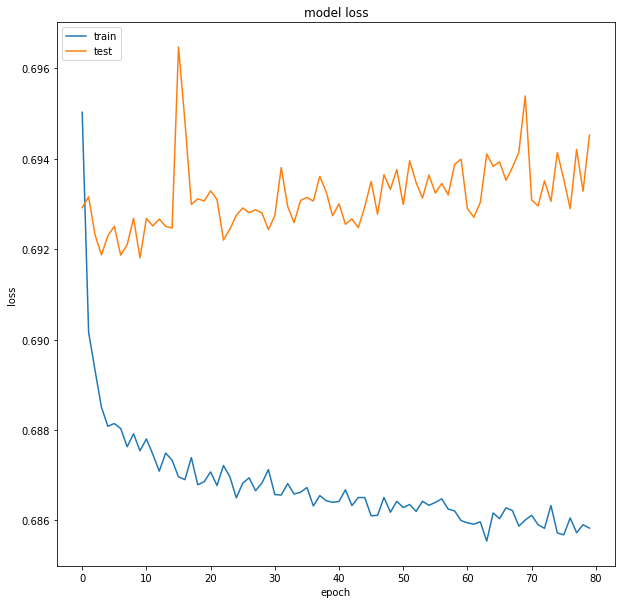

In [82]:
plot_loss_history(history)

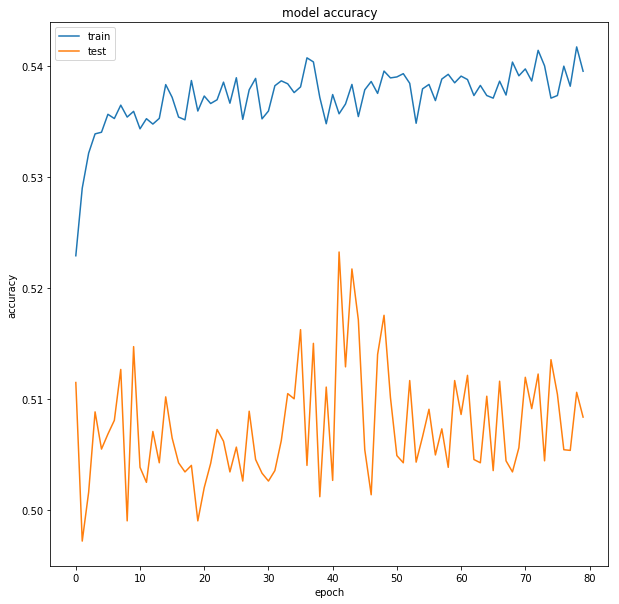

In [83]:
plot_accuracy_history(history)

In [84]:
model.save('model_5min_btc_eth.h5')